# Instance Segmentation with Detectron2 (MobileNet backbone)

## Setup

### Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
PATH = '/content/drive/My Drive/pandas-segmentation'
# os.makedirs(PATH, exist_ok = True)
os.chdir(PATH)


### Clone vovnet-detectron2 repo

In [3]:
!git clone https://github.com/youngwanLEE/vovnet-detectron2 vovnet_detectron2

Cloning into 'vovnet-detectron2'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 88 (delta 56), reused 44 (delta 25), pack-reused 0
Unpacking objects: 100% (88/88), done.


### Install Detectron2 

In [4]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.6.0+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.7.0+cu101)
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-jh0_xk9s
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-jh0_xk9s
     |████████████████████████████████| 276kB 3.5MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2-cp36-none-any.whl size=47868 sha256=db43665e8bbbaf847b290e87556725e88302cf96b2964e5dd91d107f4b9b9505
  Stored in directory: /tmp/pip-ephem-wheel-cache-jwokn_09/wheels/48/53/79/3c6485543a4455a0006f5db590ab9957622b6227011941de06
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44619 sha256=f23cd9fa0a9094f9099752b36854c8c16322c71ec0ec9a3d80e97e29e8415df6
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully

'1.6.0+cu101'

In [5]:
# !git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Obtaining file:///content/drive/My%20Drive/pandas-segmentation/detectron2_repo
     |████████████████████████████████| 2.2MB 4.5MB/s 
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp36-cp36m-linux_x86_64.whl size=266517 sha256=b85052a4d3b59f9ff05569397c5d73c0140c6d4c8369a015d19cc5c679d86229
  Stored in directory: /root/.cache/pip/wheels/68/a5/e7/56401832f23d0b2db351c5b682e466cb4841960b086da65e4e
Successfully built pycocotools
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0
  Found existing installation: pycocotools 2.0.1
    Uninstalling pycocotools-2.0.1:
      Successfully uninstalled pycocotools-2.0.1
  Running setup.py develop for detectron2


In [ ]:
!pip freeze > requirements.txt

### Register dataset

Before continuing, restart the runtime of your Jupyter Notebook.

In [2]:
import os
import numpy as np
import json
import detectron2
from detectron2.structures import BoxMode

In [3]:
import cv2
def get_image_dim(directory, json_file):
  imagename = json_file.replace('json', 'jpg')
  img = cv2.imread(imagename,)
  height, width = img.shape[:2]
  return height, width

In [4]:
def get_dataset_dicts(directory):
    classes = ['panda', 'red_panda']
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"])
        
        record["file_name"] = filename
        height, width = get_image_dim(directory, json_file)
        record["height"] = height#600
        record["width"] = width#800
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']]
            py = [a[1] for a in anno['points']]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [5]:
from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train", "test"]:
    DatasetCatalog.register("pandasH_" + d, lambda d=d: get_dataset_dicts('data/' + d))
    MetadataCatalog.get("pandasH_" + d).set(thing_classes=['panda', 'red_panda'])

In [6]:
from detectron2.data import MetadataCatalog
dataset_metadata = MetadataCatalog.get("pandasH_train")

## Visualize dataset

In [14]:
import random
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer

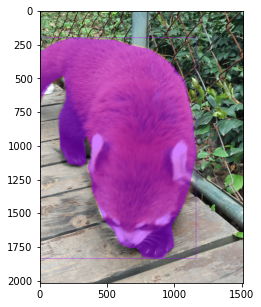

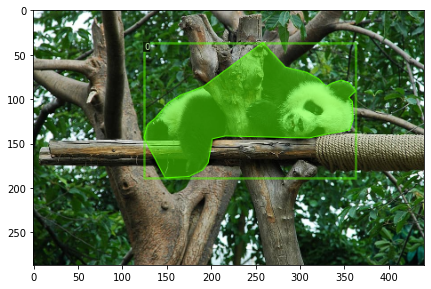

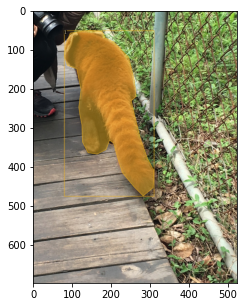

In [ ]:
dataset_dicts = get_dataset_dicts("data/train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=dataset_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (7, 5))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()


## Train model

In [8]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
cfg.merge_from_file("vovnet_detectron2/configs/mask_rcnn_Mv2_FPNLite_3x.yaml")
cfg.DATASETS.TRAIN = ("pandasH_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

Config 'vovnet_detectron2/configs/mask_rcnn_Mv2_FPNLite_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


In [10]:
from vovnet_detectron2.vovnet import mobilenet

In [11]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[09/14 00:20:51 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(24, 128, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(320, 128, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): MobileNetV2(
      (features): ModuleList(
        (0): Sequential(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): FrozenBatchNorm2d(num_features=32, eps=1e-05)
          (2)

mobilenet_v2_detectron2.pth?dl=1: 9.08MB [00:01, 6.76MB/s]                            


[09/14 00:21:57 d2.engine.train_loop]: Starting training from iteration 0


/content/drive/My Drive/pandas-segmentation/detectron2_repo/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/content/drive/My Drive/pandas-segmentation/detectron2_repo/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/content/drive/My Drive/pandas-segmentation/detectron2_repo/detectron2/layers/wrappers.py:226: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tup

[09/14 00:22:10 d2.utils.events]:  eta: 0:06:52  iter: 19  total_loss: 2.549  loss_cls: 1.159  loss_box_reg: 0.0004163  loss_mask: 0.6934  loss_rpn_cls: 0.6791  loss_rpn_loc: 0.01169  time: 0.5647  data_time: 0.4185  lr: 4.9953e-06  max_mem: 1841M
[09/14 00:22:21 d2.utils.events]:  eta: 0:09:14  iter: 39  total_loss: 1.461  loss_cls: 0.0769  loss_box_reg: 0.0005836  loss_mask: 0.6933  loss_rpn_cls: 0.6724  loss_rpn_loc: 0.0095  time: 0.5676  data_time: 0.3827  lr: 9.9902e-06  max_mem: 1841M
[09/14 00:22:35 d2.utils.events]:  eta: 0:09:46  iter: 59  total_loss: 1.398  loss_cls: 0.03073  loss_box_reg: 0.0003708  loss_mask: 0.6929  loss_rpn_cls: 0.6546  loss_rpn_loc: 0.01586  time: 0.6200  data_time: 0.5404  lr: 1.4985e-05  max_mem: 1841M
[09/14 00:22:47 d2.utils.events]:  eta: 0:09:29  iter: 79  total_loss: 1.36  loss_cls: 0.0255  loss_box_reg: 0.0002684  loss_mask: 0.6929  loss_rpn_cls: 0.6265  loss_rpn_loc: 0.01215  time: 0.6067  data_time: 0.3814  lr: 1.998e-05  max_mem: 1841M
[09/14 

## Predict on test set

In [12]:
from detectron2.engine import DefaultPredictor

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.DATASETS.TEST = ("pandasH_test", )
predictor = DefaultPredictor(cfg)

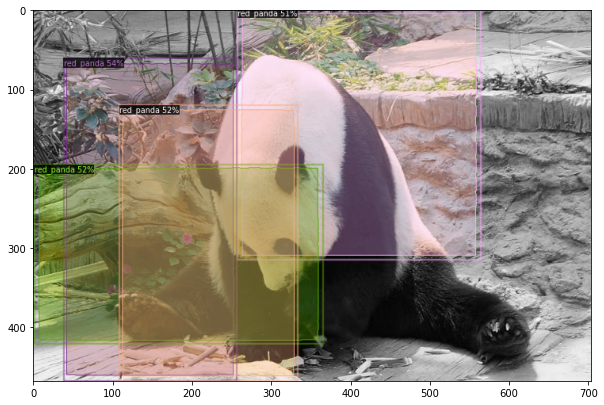

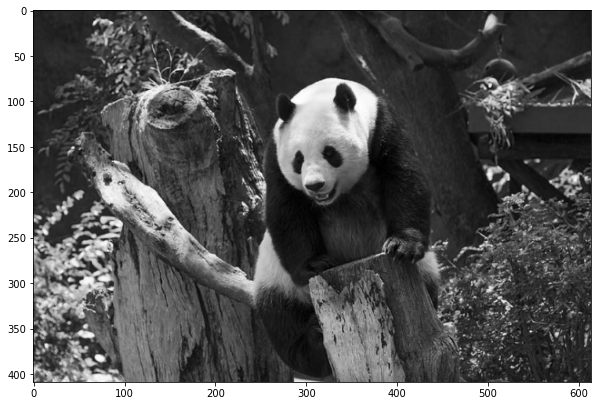

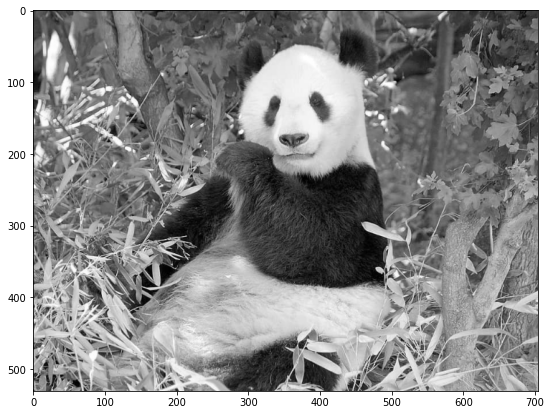

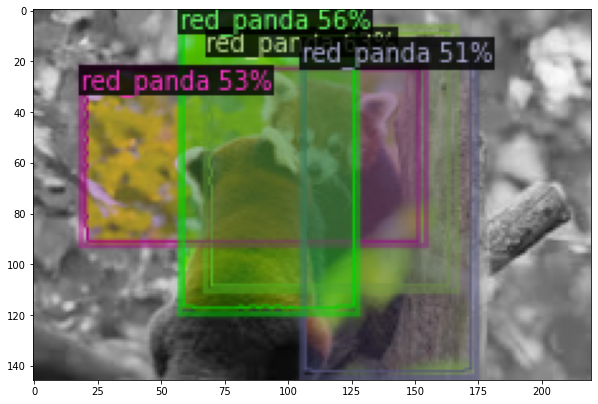

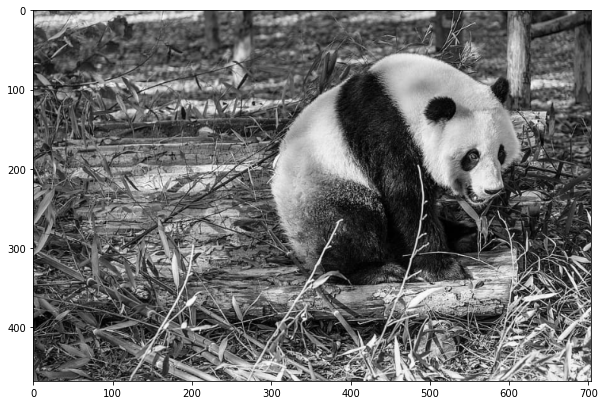

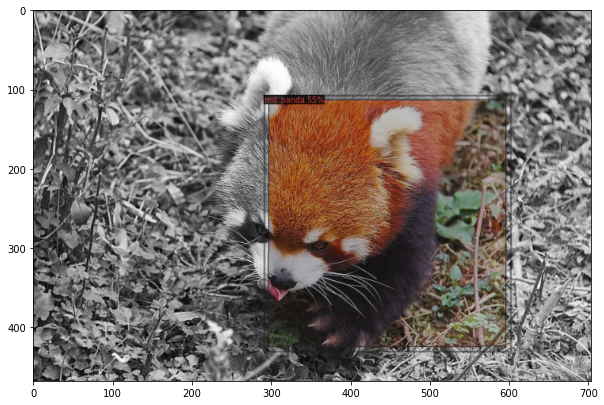

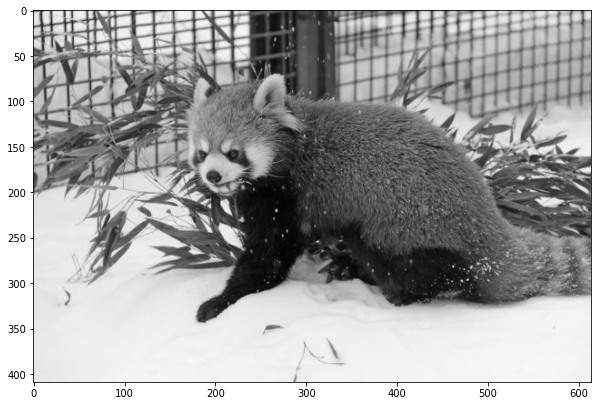

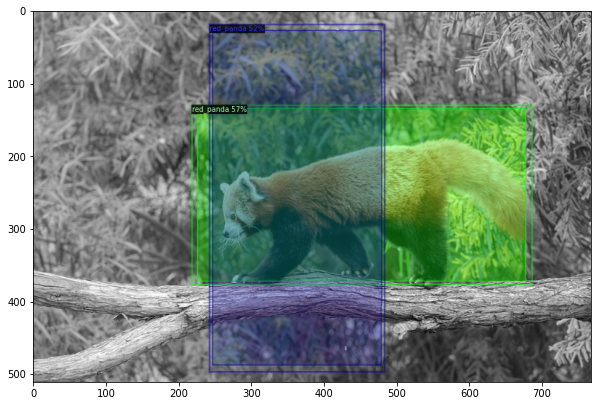

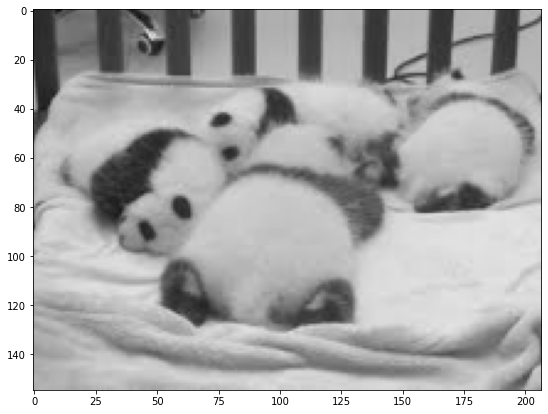

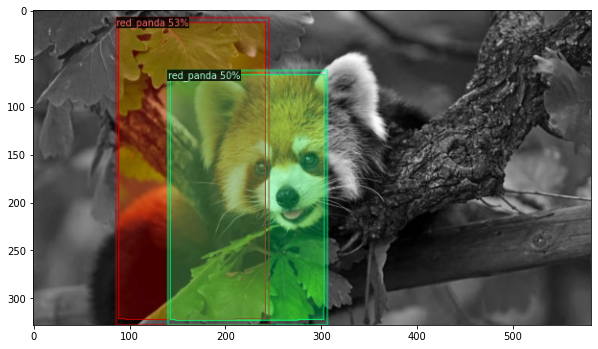

In [17]:
from detectron2.utils.visualizer import ColorMode

dataset_dicts = get_dataset_dicts('data/test')
for d in random.sample(dataset_dicts, 10):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=dataset_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (10, 7))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()